## Note, only using comments_df for now until we figure out if it is worth it to use the posts_df as well somehow

In [282]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
# some_file.py
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod4/Reddit_NLP/Scripts')
import config
pd.set_option('display.max_columns', 300)

%matplotlib inline

In [283]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

In [284]:
cursor = connection.cursor()
posts_query = "SELECT * FROM Posts"
comments_query = "SELECT * FROM Comments"

In [285]:
posts_df = pd.read_sql(posts_query, connection)
comments_df = pd.read_sql(comments_query, connection)

In [286]:
posts_df.columns = ['id_num', 'post_title', 'post_author', 'post_upvote_ratio', 'post_id', 'post_class']

In [287]:
comments_df.columns = ['id_num', 'body', 'comment_id', 'parent_id', 'post_id', 'author', 'score', 'comment_class']

In [288]:
import re

pattern = '\w+_(\w+)'
p = re.compile(pattern)

In [289]:
comments_df.post_id = comments_df.post_id.apply(lambda x: p.findall(x)[0])

In [290]:
# GET RID OF NEGATIVE SCORES (a negative score in a conservative subreddit could be a brigader for example)
comments_df = comments_df[comments_df.score > 0]

In [291]:
df = comments_df[['body', 'comment_class']]

In [292]:
df.comment_class.value_counts()

left     26554
right    22231
Name: comment_class, dtype: int64

In [293]:
from sklearn.utils import resample
right = df[df.comment_class == 'right']
left = df[df.comment_class == 'left']

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in majority class
                          random_state=42) 
df = pd.concat([left, right_upsampled])
df.comment_class.value_counts()

right    26554
left     26554
Name: comment_class, dtype: int64

In [294]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [295]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [296]:
def capital_percentage(comment):
    tokens = nltk.word_tokenize(comment)
    cap_count = 0
    for item in tokens:
        if item.isupper():
            cap_count += 1
    return cap_count/len(tokens)



In [299]:
df['capital_percentage'] = df.body.apply(capital_percentage)

,body,comment_class,capital_percentage
449,"As a Lesbian, I get a lot of backlash when peo...",left,0.026549
450,yippee,left,0.000000
475,“*These are radical islamic terrorists and she...,left,0.032520
476,I hope Gov. Whitmer still has all that extra s...,left,0.029412
477,She's not wrong. I hope this woman goes places...,left,0.035714
...,...,...,...
3535,Looks like this think tank is more likely to ...,right,0.058252
2165,He killed Tupac.. seriously,right,0.000000
38990,I mean that is misleading because those arabic...,right,0.031746
43693,I cant wait to see more and more animals being...,right,0.100000


In [321]:
all_caps = df[df.capital_percentage == 1].sort_values(by='capital_percentage', 
                                                      ascending=False).comment_class.value_counts()

In [323]:
comments_w_most_caps = df.sort_values(by='capital_percentage', 
                                      ascending=False).iloc[0:500].comment_class.value_counts()

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

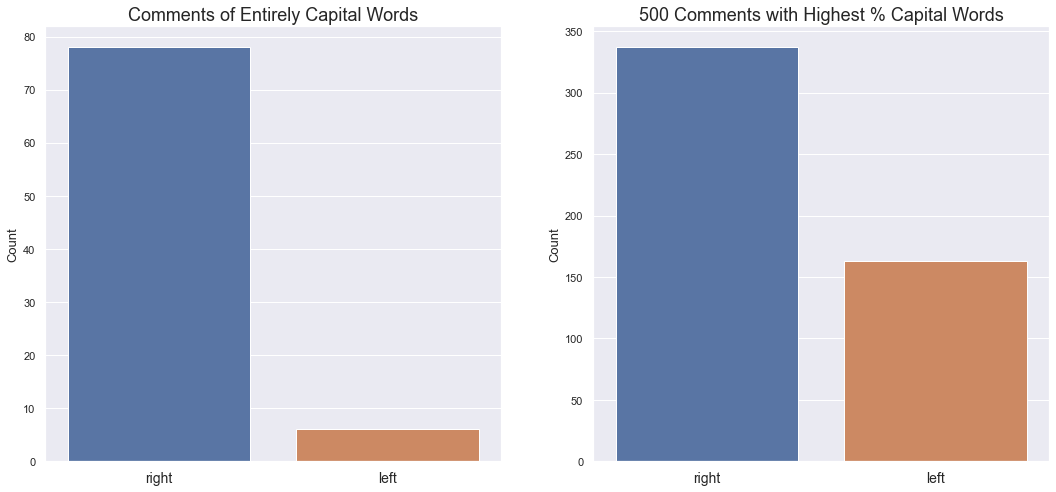

In [336]:
fig = plt.figure(figsize=(18,8))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(all_caps.index, all_caps, ax=ax1)
plt.title("Comments of Entirely Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)

ax2 = plt.subplot(1, 2, 2)
sns.barplot(comments_w_most_caps.index, comments_w_most_caps, ax=ax2)
plt.title("500 Comments with Highest % Capital Words", fontsize = 18)
plt.ylabel("Count", fontsize=13)
plt.xticks(fontsize=14)


In [230]:
leaning_map = {'right': 1, 'left': 0}
df.comment_class = df.comment_class.map(leaning_map)

In [231]:
df['text_len'] = df['body'].map(lambda x: len(x))

In [232]:
df = df[df.text_len >= 100]
df.drop('text_len', axis=1, inplace=True)

In [233]:
df.comment_class.value_counts()

1    13357
0    12810
Name: comment_class, dtype: int64

In [234]:
X = df['body']
y = df['comment_class']

#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re"]

In [235]:
# we can define a function that removes stopwords 
def process_comment(comment):
    comment = comment.lower()
    tokens = nltk.word_tokenize(comment)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [236]:
#apply above function to data

processed_comments = list(map(process_comment, X))

In [237]:
#create list with lemmatized output
lemmatized_output = []

for comment in processed_comments:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in comment])
    lemmatized_output.append(lemmed)

In [238]:
X_lem = lemmatized_output

y_lem = y

In [239]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.35, random_state=1)
tfidf = TfidfVectorizer(ngram_range=(1,2))

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

tfidf_data_train_lem

<17008x283787 sparse matrix of type '<class 'numpy.float64'>'
	with 971786 stored elements in Compressed Sparse Row format>

In [240]:
df_freq_right = df[df['comment_class']==1]
df_freq_left = df[df['comment_class']==0]

data_right = df_freq_right['body']
data_left = df_freq_left['body']

processed_right = list(map(process_comment, data_right))
processed_left = list(map(process_comment, data_left))

In [241]:
# Preprocessing:
# We will use these again later on
# FORMAT:  flat_list = [item for sublist in l for item in sublist]

flat_right = [item for sublist in processed_right for item in sublist]
flat_left = [item for sublist in processed_left for item in sublist]

In [242]:
right_freq = FreqDist(flat_right)
left_freq = FreqDist(flat_left)

In [243]:
right_freq.most_common(20)

[('people', 3833),
 ('gun', 3559),
 ('republicans', 2556),
 ('like', 2529),
 ('vote', 2490),
 ('would', 2277),
 ('get', 1887),
 ('https', 1860),
 ('right', 1844),
 ('one', 1836),
 ('guns', 1766),
 ('sub', 1683),
 ('subreddit', 1590),
 ('trump', 1553),
 ('perspective', 1537),
 ('want', 1474),
 ('think', 1453),
 ('even', 1442),
 ('...', 1358),
 ('biden', 1354)]

In [244]:
left_freq.most_common(20)

[('trump', 5107),
 ('https', 4305),
 ('people', 3775),
 ('vote', 3299),
 ('please', 2713),
 ('subreddit', 2476),
 ('voting', 2333),
 ('like', 2223),
 ('would', 2008),
 ('questions', 1716),
 ('biden', 1711),
 ('see', 1594),
 ('get', 1569),
 ('one', 1387),
 ('even', 1206),
 ('going', 1159),
 ('...', 1146),
 ('early', 1106),
 ('media', 1095),
 ('think', 1058)]

In [245]:
# create counts of satire and not satire with values and words
right_bar_counts = [x[1] for x in right_freq.most_common(25)]
right_bar_words = [x[0] for x in right_freq.most_common(25)]

left_bar_counts = [x[1] for x in left_freq.most_common(25)]
left_bar_words = [x[0] for x in left_freq.most_common(25)]

In [246]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

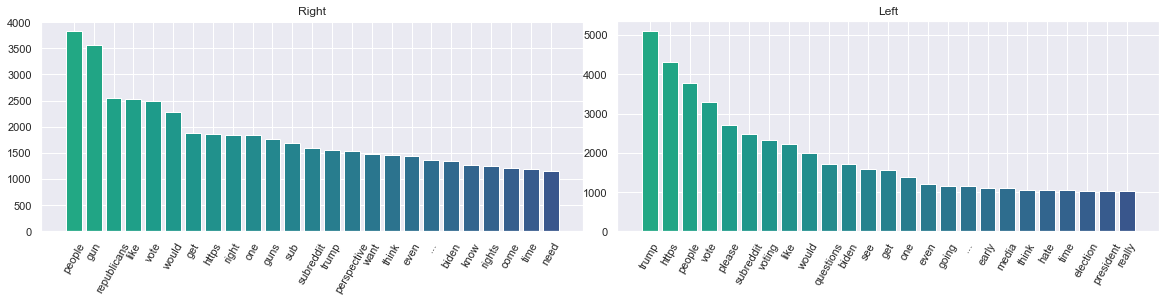

In [247]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(right_bar_words, right_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(left_bar_words, left_bar_counts, color=color )

ax.title.set_text('Right')
ax2.title.set_text('Left')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

In [248]:
# Getting our data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
right_dictionary = dict(zip(right_bar_words, right_bar_counts))
left_dictionary = dict(zip(left_bar_words, left_bar_counts))

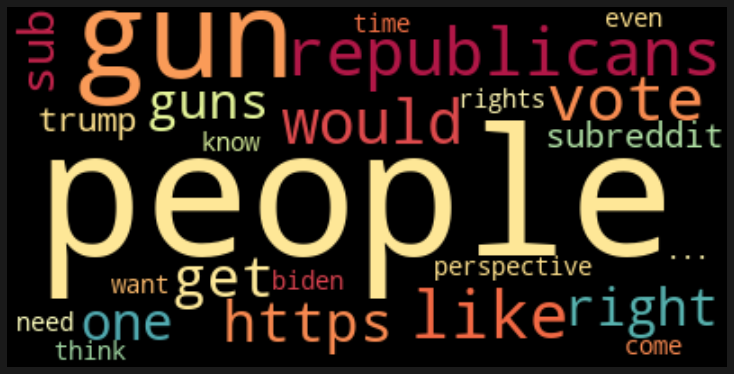

In [249]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(right_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

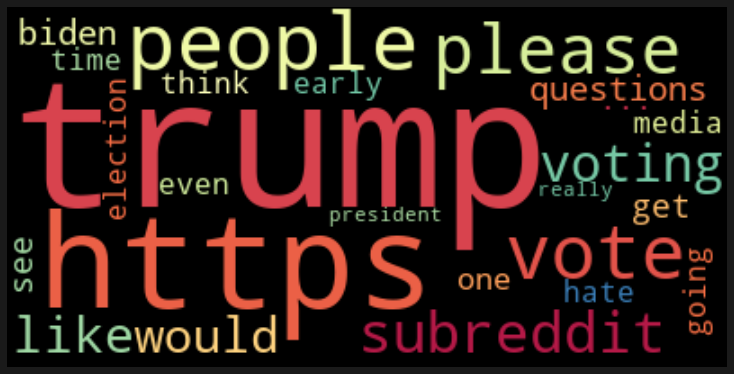

In [250]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(left_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

## Random Forest

In [251]:
rfc_lemma = RandomForestClassifier(n_estimators=100,random_state=0, class_weight='balanced')
rfc_lemma.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds = rfc_lemma.predict(tfidf_data_test_lem)

rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print()
print("F1 Score: {:.4}".format(rf_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.864

F1 Score: 0.8647


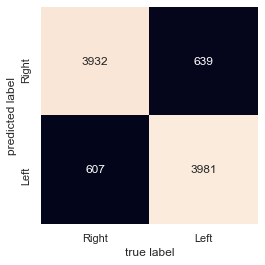

In [252]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, rf_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## MN Naive Bayes

In [253]:
mnb_lemma = MultinomialNB()
mnb_lemma.fit(tfidf_data_train_lem, y_train_lem)
mnb_test_preds = mnb_lemma.predict(tfidf_data_test_lem)

mnb_acc_score_lem = accuracy_score(y_test_lem, mnb_test_preds)
mnb_f1_score_lem = f1_score(y_test_lem, mnb_test_preds)
print('Multinomial Naive Bayes model accuracy')
print("Testing Accuracy: {:.4}".format(mnb_acc_score_lem))
print()
print("F1 Score: {:.4}".format(mnb_f1_score_lem))

Multinomial Naive Bayes model accuracy
Testing Accuracy: 0.8298

F1 Score: 0.8451


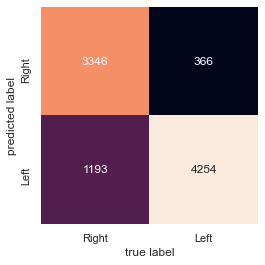

In [254]:
mat = confusion_matrix(y_test_lem, mnb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Right', 'Left'], yticklabels=['Right', 'Left'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [255]:
y_test_lem.index

Int64Index([ 6209,  4734, 12167, 20456, 21644, 25227, 14265, 24996, 42788,
            45128,
            ...
            13515, 16180, 34028,  1662, 18860, 50355, 36634, 42562,  6230,
             4663],
           dtype='int64', length=9159)

In [261]:
test = comments_df.loc[y_test_lem.index]
test['pred'] = rf_test_preds
test['pred'] = test['pred'].apply(lambda x: 'right' if x == 1 else 'left')

In [262]:
guessed_right_wrong = test[(test.comment_class != test.pred) & (test.pred == 'right')]
guessed_right_wrong.reset_index(drop=True, inplace=True)

guessed_left_wrong = test[(test.comment_class != test.pred) & (test.pred == 'left')]
guessed_left_wrong.reset_index(drop=True, inplace=True)


In [263]:
print("GUESSED RIGHT BUT WE WERE WRONG")
print("_______________________________")
for i in range(0,50):
    print(guessed_right_wrong.iloc[i].body)

GUESSED RIGHT BUT WE WERE WRONG
_______________________________
We want nothing to do with that bloated orange idiot here in the UK. We have enough of our own idiots trying to destroy our lives without this abomination’s input.
Tribalism is so strong in some people that they would rather burn their own house down then have anyone in it who doesn't agree with them.
Socialism!!! Can't have a bunch of educated free thinkers running around who will buy all the guns to defend their families and teach christianity in the schools!!!
So Collins is totally going to vote to impeach this time, right? Since he definitely didn’t learn anything the first time he was impeached.
Many conservatives believe an adherence to the law as it was written without interrupting it for modern times. That is why many are Bible thumpers as well. These people fear change and the world outside their control.
She is that babysitter who assures the parents there won't be any trouble, but gives the child coffee, cigaret

In [264]:
print("GUESSED LEFT BUT WE WERE WRONG")
print("______________________________")
for i in range(0,50):
    print(guessed_left_wrong.iloc[i].body)

GUESSED LEFT BUT WE WERE WRONG
______________________________
View in your timezone:  
[tonight at 7pm ET][0]  

[0]: https://timee.io/20201015T2300?tl=AMA%20with%20Congressional%20Candidate%20Anthony%20Rogers%20MO-1%20tonight%20at%207pm%20ET.
Go easy. He's not out of the woods yet. The guy has so many different cocktails of meds and antibodies in his system, that it could be literally propping him up, hence the "best I've felt in 20yrs" statement. Let's see where he's at in a week.
Bubba gave the Chi Com's a lot of our technology so Obama, not to be outdone, gave Iran at pallet of cash
Win or lose President Trump should fire him the day after the election and tell the American people why in a prime time address.
Hannity writes 10 questions for Biden 

Tapper writes 10 questions for Trump

Just before the debates start, Hannity gets to cut 3 of Tapper’s questions, and Tapper gets to cut 3 of Hannity’s. 

(Can be anyone equiv to Hannity or Tapper)
Maybe they should focus on making good 

Well, if Trump wins, impeachment proceedings will commence.  And the results of a senate vote probably will not be a sure thing.  Buy your guns now.
This is something liberals convinced themselves of in the Bush years, because the media was so enamored of war that they did give Bush undue deference for a while. But one President's first term isn't really the entire last half century.
